# CIS6800: Project 2: YOLO
### Due:
* Part A - Sept. 18 at 11:59 p.m.
* Part B - Sept. 25 at 11:59 p.m.

### Instructions:
* Part A consists of parts 1-4 and is due on September 18th at 11:59 p.m. EDT.
* Part B consists of parts 5-8 and is due on September 25th at 11:59 p.m. EDT.
* As the autograder uses the definitions for functions and classes you submit,
please do not modify the name of any function or class provided.
* This is a group assignment with one submission per group. It is expected that each member of the group will contribute to solving each question. Be sure to specify your teammates when you submit to Gradescope! Collaborating with other groups is not permitted.
* There is no single answer to most problems in deep learning, therefore the questions will often be underspecified. You need to fill in the blanks and submit a solution that solves the (practical) problem. Document the choices (hyperparameters, features, neural network architectures, etc.) you made where specified.
* All the code should be written in Python.
* You may include any code used in previous projects.

## Introduction
Object detection is a fundamental task in computer vision. The problem of object recognition essentially consists of first localizing the object and then classifying it with a semantic label. In recent deep learning based methods, YOLO is an extremely fast real time multi object detection algorithm.  
  
<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_1.png"/></div>
<center>Figure 1: This is a demo of what object detection does. The color indicates different semantic class.</center>  
  
In this project, we provide 10K street scene images with correponding labels as training data. The image dimension is $128 \times 128 \times 3$, and the labels include the semantic class and the bounding box corresponding to each object in the image. Note that a small portion of these ground-truth labels are not a little bit noisy and the quantity of the training set is not very large, so we do not expect you to learn a super robust object detector.

## Data Preprocessing
For this section, you will need to write code to preprocess the ground truth labels for the YOLO algorithm. The
labels are provided in the "label" folder. The format of the labels are (class, $x_1$, $y_1$, $x_2$, $y_2$), where $x_1$, $y_1$ are the top left corner of the bounding box and $x_2$, $y_2$ are the bottom right corner of the bounding box.  
  
<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_2.png"/></div>
<center>Figure 2: This figure demonstrates the format of ground-truth labels that YOLO algorithm requires.</center>  
  
For each image, you are required to convert the provided labels into the $8 \times 8 \times 8$ ground truth matrix, which has the same dimension as the output of YOLO detection network. The instructions of this conversion is as follows:
* We consider a $16 \times 16$ image patch as a grid cell and thus divide the full image into $8 \times 8$ patches in the 2D spatial dimension. In the output activation space, one grid cell represents one 16x16 image patch with corresponding aligned locations.
* For simplified YOLO, we only use one anchor box, where we assume the anchor size is the same as the grid cell size. If the center of an object falls into a grid cell, that grid cell is responsible for detecting that object. This means that there is only one anchor for each object instance.
* For each anchor, there are 8 channels, which encode Pr(Objectness), $x$, $y$, $w$, $h$, P(class=pedestrian),  P(class=traffic light), and P(class=car).
* The Pr(Objectness) is the probability of whether this anchor is an object or background. When assigning the ground-truth for this value, "1" indicates object and "0" indicates background.
* The channels 2-5, $x$, $y$ coordinates represent the center of the box relative to the bounds of the grid cell; $w$, $h$ is relative to the image width and height.
* In channels 6-8, you need to convert the ground truth semantic label of each object into one-hot coding for each anchor boxes.
* Note that if the anchor box does not have any object (Pr=0), you donâ€™t need to assign any values to channels 2-8, since we will not use them during training.
* The dimensions are ordered (channels, x, y).

## Model Architecture
You are required to implement the model architecture using the following parameters. This model takes input with dimension of $128 \times 128 \times 3$ and outputs an activation with dimension of $8 \times 8 \times 8$.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_3.png"/></div>
<center>Figure 3: This figure demonstrates how to compute IoU.</center>

| Layer | Hyperparameters |
| :-: | :-: |
| conv1 | Kernel size $= 4 \times 4 \times 32$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv2 | Kernel size $= 4 \times 4 \times 64$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv3 | Kernel size $= 4 \times 4 \times 128$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv4 | Kernel size $= 4 \times 4 \times 256$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv5 | Kernel size $= 4 \times 4 \times 512$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv6 | Kernel size $= 4 \times 4 \times 1024$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| transposed_conv7 | Kernel size $= 4 \times 4 \times 256$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| transposed_conv8 | Kernel size $= 4 \times 4 \times 64$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv9 | Kernel size $= 3 \times 3 \times 8$, stride $=1$, pad $=1$. |


## Training Details
During training, the localization and classification errors are optimized jointly. The loss function is shown
as below.  $i$ indicates number of grid cells and $j$ indicates number of anchor boxes at each grid cell. In our
case, there is only one anchor box at each grid cell and $B = 1$.

$$ \text{Loss} = 
{\lambda_\text{coord} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left[{\left(x_i - \hat{x}_i\right)}^2 + {\left(y_i - \hat{y}_i\right)}^2\right]} + 
{\lambda_\text{coord} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left[{\left(\sqrt{w_i} - \sqrt{\hat{w}_i}\right)}^2 + {\left(\sqrt{h_i} - \sqrt{\hat{h}_i}\right)}^2\right]} + 
{\sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left(C_i - \hat{C}_i\right)^2} + 
{\lambda_\text{no obj} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{no obj} \left(C_i - \hat{C}_i\right)^2} + 
{\sum_{i=0}^{S^2} \mathbb{1}_{ij}^\text{obj} \sum_{c\, \in\, \text{classes}} \left(p_i(c) - \hat{p}_i(c)\right)^2}$$

* In our case there is only one anchor box at each grid, hence $B = 1$.
* $S^2 =$ total number of grid cells.
* $\mathbb{1}_{ij}^\text{obj} = 1$ if an object appears in grid cell $i$ and 0 otherwise.
* $\mathbb{1}_{ij}^\text{no obj}$ is the compliment of $\mathbb{1}_{ij}^\text{obj}$.
* $\hat{C}_i =$ Box confidence score $=$ Pr(box contains object) $\times$ IoU
* IoU $=$ Intersection over union between the predicted and the ground truth.
* $\hat{p}_i(c) =$ conditional class probability of class $c$ in cell $i$.

$\lambda_\text{coord}$ and and $\lambda_\text{no obj}$ are two hyperparameters for coordinate predictions and non-objectness classification. We set $\lambda_\text{coord} = 5$ and and $\lambda_\text{no obj} = 0.5$.

Each grid cell predicts 1 bounding box, confidence score for those boxes and class conditional probabilities.

The confidence Score reflects the degree of confidence that the box contains an object and how accurate the box is. If no object exists in the cell then the confidence score should be 0 else the confidence score should be equal to the IOU between the predicted box and the ground truth box.

During training, you can set learning rate of 10e-3 using Adam optimizer with default beta 1 and beta 2. You are encourage to adaptively adjust learning rate during training to see if the model will converge better. You should also visualize the loss over training iterations. You will need to decide at the iteration to stop training based on the loss visualization. (At least 20 epochs of training is required.)

## Post-Processing
During inference, the network is going to predict lots of overlapping redundant bounding boxes. To eliminate the redundant boxes, there are basically two steps:

1. Get rid of predicted boxes with low objectness probability (Pr $< 0.6$).
2. For each class, calculate the IoU for all the bounding boxes and cluster boxes with IoU > 0.5 as a group. For each group, find the one with highest Pr and suppress the other boxes. This is referred as non-max suppression.

To evaluate the performance of your YOLO implementation, compute the mean Average Precision (mAP) of inference. Predicted bounding boxes are a match with ground truth bounding boxes if they share the same label and have an IoU with the ground truth bounding box of greater than 0.5. These matches can be used to calculate a precision/recall curve for each class. The Average Precision for a class is the area under this curve. The mean of these Average Precision values over all the classes in inference gives the mean Average Precision of your network.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_4.png"/></div>
<center>Figure 4: This figure demonstrates post-process of how to get rid of redundant bounding box.</center>

## Code

In [1]:
# !pip install pytorch_lightning &> /dev/null

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
seed = 17
torch.manual_seed(seed);

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# # Use this function to import the provided data files
# def load_data(file_name):
#     return np.load(file_name, allow_pickle=True, encoding='latin1')['arr_0']

# images = load_data('/content/drive/MyDrive/CIS680/images.npz')
# raw_labels = load_data('/content/drive/MyDrive/CIS680/labels.npz')

## CHange process labels

In [4]:
# This function should compute the 8X8X8 label from the raw labels for the corresponding image.
def process_labels(raw_labels):
    # raw_labels=raw_labels[0]
    label_mat = np.zeros((8,8,8))
    arr_1 = raw_labels
    # print(arr_1)
    # wx , wy = (arr_1[:,1]+ arr_1[:,3])/2, (arr_1[:,2]+ arr_1[:,4])/2
    wx , hy = np.abs(arr_1[:,1] - arr_1[:,3])/128, np.abs(arr_1[:,2] - arr_1[:,4])/128
    x1,y1 = (arr_1[:,1]), (arr_1[:,2])
    x2,y2 = (arr_1[:,3]), (arr_1[:,4])
    cx, cy = (x1+x2)/(16*2), (y1+y2)/(2*16)
    patchx, patchy = cx.astype(int), cy.astype(int)
    cxp,cyp = cx-patchx, cy-patchy
    # print(patchy)
    label_mat[0, patchy, patchx] = 1
    label_mat[1, patchy, patchx] = cxp
    label_mat[2, patchy, patchx] = cyp
    label_mat[3, patchy, patchx] = wx
    label_mat[4, patchy, patchx] = hy
    a = arr_1[:,0].astype(int)
    b = np.zeros((a.size, 3)) #beacuse encoding has to be of shape 3
    b[np.arange(a.size), a] = 1
    label_mat[5:, patchy, patchx] = b.T
    return label_mat

In [5]:
def process_labels(raw_labels):

    labels=np.zeros((8,8,8))
   

    for each_row in raw_labels:
      if(each_row[0]==0):
        # rows_of_ped=np.where(raw_labels[:,0]==0)[0]

        center_x_ped = (each_row[1]+each_row[3])/2.0
        center_y_ped = (each_row[2]+each_row[4])/2.0
        
        ##row column and grid cell vaala natak
        grid_x_ped = np.floor(center_x_ped/16).astype(np.int32)
        grid_y_ped = np.floor(center_y_ped/16).astype(np.int32)
        
        labels[0,grid_y_ped,grid_x_ped]=1
        labels[1,grid_y_ped,grid_x_ped]=(center_x_ped-16*grid_x_ped)/16
        labels[2,grid_y_ped,grid_x_ped]=(center_y_ped-16*grid_y_ped)/16
        labels[3,grid_y_ped,grid_x_ped]=(each_row[3]-each_row[1])/128.0
        labels[4,grid_y_ped,grid_x_ped]=(each_row[4]-each_row[2])/128.0
        labels[5,grid_y_ped,grid_x_ped]=1
        labels[6,grid_y_ped,grid_x_ped]=0
        labels[7,grid_y_ped,grid_x_ped]=0
      
      if(each_row[0]==1):
        center_x_tl = (each_row[1]+each_row[3])/2.0
        center_y_tl = (each_row[2]+each_row[4])/2.0


        grid_x_tl = np.floor(center_x_tl/16).astype(np.int32)
        grid_y_tl = np.floor(center_y_tl/16).astype(np.int32)


        labels[0,grid_y_tl,grid_x_tl]=1
        labels[1,grid_y_tl,grid_x_tl]=(center_x_tl-16*grid_x_tl)/16
        labels[2,grid_y_tl,grid_x_tl]=(center_y_tl-16*grid_y_tl)/16
        labels[3,grid_y_tl,grid_x_tl]=(each_row[3]-each_row[1])/128.0
        labels[4,grid_y_tl,grid_x_tl]=(each_row[4]-each_row[2])/128.0
        labels[5,grid_y_tl,grid_x_tl]=0
        labels[6,grid_y_tl,grid_x_tl]=1
        labels[7,grid_y_tl,grid_x_tl]=0

      if(each_row[0]==2):
        center_x_car = (each_row[1]+each_row[3])/2.0
        center_y_car = (each_row[2]+each_row[4])/2.0


        grid_x_car = np.floor(center_x_car/16).astype(np.int32)
        grid_y_car = np.floor(center_y_car/16).astype(np.int32)


        labels[0,grid_y_car,grid_x_car]=1
        labels[1,grid_y_car,grid_x_car]=(center_x_car-16*grid_x_car)/16
        labels[2,grid_y_car,grid_x_car]=(center_y_car-16*grid_y_car)/16
        labels[3,grid_y_car,grid_x_car]=(each_row[3]-each_row[1])/128.0
        labels[4,grid_y_car,grid_x_car]=(each_row[4]-each_row[2])/128.0
        labels[5,grid_y_car,grid_x_car]=0
        labels[6,grid_y_car,grid_x_car]=0
        labels[7,grid_y_car,grid_x_car]=1



    return labels

In [6]:
label_aug = np.zeros((images.shape[0], 8,8,8))
# print(images.shape[0])
for j in range(images.shape[0]):
  label_aug[j] = process_labels(raw_labels[j])

In [7]:
def reconstruct_raw_labels(labels, img_dim=128):
    
    # obj_present_i,obj_present_j=np.where(labels[0]==1)
    
    # print(labels)
    ped_i,ped_j=np.where(labels[5,:,:]==1)
    tl_i,tl_j=np.where(labels[6,:,:]==1)
    car_i,car_j=np.where(labels[7,:,:]==1)
    # print(car_i)
    # print(car_j)

    number_of_ped=len(ped_i)
    number_of_car=len(car_i)
    number_of_tl=len(tl_i)
    total_objects=np.sum(labels[5:,:,:]==1)
    
    reconstruct_raw_label=np.zeros((total_objects,5))
    row_id_total=0

    # print(number_of_car)
    for idx in range(0,number_of_ped):
      center_x = labels[1,ped_i[idx],ped_j[idx]]*16+16*ped_j[idx]
      center_y = labels[2,ped_i[idx],ped_j[idx]]*16+16*ped_i[idx]
      width = labels[3,ped_i[idx],ped_j[idx]]*128
      height = labels[4,ped_i[idx],ped_j[idx]]*128

      x1 = center_x - 0.5 * width
      y1 = center_y - 0.5 * height
      x2 = center_x + 0.5 * width
      y2 = center_y + 0.5 * height
      reconstruct_raw_label[row_id_total,:]=np.array([0,x1,y1,x2,y2])
      row_id_total+=1

    for idx in range(0,number_of_tl):
      center_x = labels[1,tl_i[idx],tl_j[idx]]*16+16*tl_j[idx]
      center_y = labels[2,tl_i[idx],tl_j[idx]]*16+16*tl_i[idx]
      width = labels[3,tl_i[idx],tl_j[idx]]*128
      height = labels[4,tl_i[idx],tl_j[idx]]*128

      x1 = center_x - 0.5 * width
      y1 = center_y - 0.5 * height
      x2 = center_x + 0.5 * width
      y2 = center_y + 0.5 * height
      reconstruct_raw_label[row_id_total,:]=np.array([1,x1,y1,x2,y2])
      row_id_total+=1
    
    for idx in range(0,number_of_car):
      center_x = labels[1,car_i[idx],car_j[idx]]*16+16*car_j[idx]
      center_y = labels[2,car_i[idx],car_j[idx]]*16+16*car_i[idx]

      width = labels[3,car_i[idx],car_j[idx]]*128
      height = labels[4,car_i[idx],car_j[idx]]*128

      

      x1 = center_x - 0.5 * width
      y1 = center_y - 0.5 * height
      x2 = center_x + 0.5 * width
      y2 = center_y + 0.5 * height
      reconstruct_raw_label[row_id_total,:]=np.array([2,x1,y1,x2,y2])
      row_id_total+=1
   
  
  

    return reconstruct_raw_label

In [8]:
def yolo_loss(output, target):
    out_mask_obj = output[:,0,:,:]
    out_x = output[:,1,:,:]
    out_y = output[:,2,:,:]
    out_w = output[:,3,:,:]
    out_h = output[:,4,:,:]
    tar_mask_obj = target[:,0,:,:]
    tar_x = target[:,1,:,:]
    tar_y = target[:,2,:,:]
    tar_w = target[:,3,:,:]
    tar_h = target[:,4,:,:]
    lambda_coord = 5
    first_term = lambda_coord*torch.sum(tar_mask_obj*((out_x - tar_x)**2 + (out_y-tar_y)**2))
    second_term = lambda_coord*torch.sum(tar_mask_obj*((torch.sqrt(out_w) - torch.sqrt(tar_w))**2 + (torch.sqrt(out_h)-torch.sqrt(tar_h))**2))
    
    ind_i,ind_j=torch.meshgrid(torch.arange(0,8).to(device),torch.arange(0,8).to(device)) #beacuse we need to find grid left upper corner first
    ind_i, ind_j = 16*ind_i, 16*ind_j 

    tar_oldx = (tar_x*16+ ind_j)[tar_mask_obj==1]
    tar_oldy = (tar_y*16+ ind_i)[tar_mask_obj==1]
    tar_oldw = (tar_w*128)[tar_mask_obj==1]
    tar_oldh = (tar_h*128)[tar_mask_obj==1]

    out_oldx = (out_x*16+ ind_j)[tar_mask_obj==1]
    out_oldy = (out_y*16+ ind_i)[tar_mask_obj==1]
    out_oldw = (out_w*128)[tar_mask_obj==1]
    out_oldh = (out_h*128)[tar_mask_obj==1]

    x1_tar = tar_oldx - 0.5 * tar_oldw
    y1_tar = tar_oldy - 0.5 * tar_oldh
    x2_tar = tar_oldx + 0.5 * tar_oldw
    y2_tar = tar_oldy + 0.5 * tar_oldh

    x1_out = out_oldx - 0.5 * out_oldw
    y1_out = out_oldy - 0.5 * out_oldh
    x2_out = out_oldx + 0.5 * out_oldw
    y2_out = out_oldy + 0.5 * out_oldh



    tar_boxinfo=torch.stack([x1_tar,y1_tar,x2_tar,y2_tar]).T
    out_boxinfo=torch.stack([x1_out,y1_out,x2_out,y2_out]).T

    IOU=torch.diag(torchvision.ops.box_iou(tar_boxinfo,out_boxinfo))

    # third_term = torch.sum((IOU*tar_mask_obj[tar_mask_obj==1] - out_mask_obj[tar_mask_obj==1])**2)
    third_term = torch.sum((tar_mask_obj[tar_mask_obj==1] - out_mask_obj[tar_mask_obj==1])**2)

    lambda_noobj = 0.5
    fourth_term = lambda_noobj*(torch.sum((out_mask_obj[tar_mask_obj!=1])**2))

    fifth_term = torch.sum(tar_mask_obj*((target[:,5,:,:] - output[:,5,:,:])**2 +   (target[:,6,:,:] - output[:,6,:,:])**2 + (target[:,7,:,:] - output[:,7,:,:])**2  ))

    loss = first_term + second_term + third_term + fourth_term + fifth_term


    return loss

In [9]:
def reconstruct_model_pred_to_bbox(model_preds):
  label_pred=[]
  for model_pred in model_preds:
    class_prediction=model_pred[5:,:,:].clone()
    zero_mask = torch.logical_and(torch.logical_and(class_prediction[0,:,:]==0,class_prediction[1,:,:]==0),class_prediction[2,:,:]==0)    
  

    index_i,index_j=torch.meshgrid(torch.arange(0,8),torch.arange(0,8),indexing='ij')
    non_zero_indices_i=index_i[~zero_mask]
    non_zero_indices_j=index_j[~zero_mask]
    
    classes=model_pred[5:,non_zero_indices_i,non_zero_indices_j].argmax(dim=0)
    obj_confidence=model_pred[0,non_zero_indices_i,non_zero_indices_j]

    center_x = model_pred[1,non_zero_indices_i,non_zero_indices_j]*16+16*non_zero_indices_j
    center_y = model_pred[2,non_zero_indices_i,non_zero_indices_j]*16+16*non_zero_indices_i
    width = model_pred[3,non_zero_indices_i,non_zero_indices_j]*128
    height = model_pred[4,non_zero_indices_i,non_zero_indices_j]*128

    x1 = center_x - 0.5 * width
    y1 = center_y - 0.5 * height
    x2 = center_x + 0.5 * width
    y2 = center_y + 0.5 * height
    
    bbox=torch.hstack((x1.reshape(-1,1),y1.reshape(-1,1),x2.reshape(-1,1),y2.reshape(-1,1)))

    ## for 0th prediction
    ped_indices=np.where(classes==0)[0]  
    tl_indices=np.where(classes==1)[0]
    car_indices=np.where(classes==2)[0]
    

  
    labels=np.array([]).reshape(0,5)


    labels_ped=bbox[ped_indices]
    ped=torch.hstack((torch.zeros((labels_ped.shape[0],1)),labels_ped))
    
    labels_tl=bbox[tl_indices]
    tl=torch.hstack((1*torch.ones((labels_tl.shape[0],1)),labels_tl))

    labels_car=bbox[car_indices]
    car=torch.hstack((2*torch.ones((labels_car.shape[0],1)),labels_car))

    label_pred.append(torch.vstack((ped,tl,car)).numpy())
    
    
    
   



  return label_pred

In [10]:
def probability_filtering(model_preds, img_dim=128):
    
    
    probability_mask=(model_preds[:,0,:,:]>=0.6).reshape(model_preds.shape[0],1,8,8)    
    # print(probability_mask.shape)
    model_preds=model_preds*probability_mask
    return model_preds

In [11]:
def NMS_bbox_gradescope(confidences,indices,bbox):
  from copy import deepcopy
  conf=deepcopy(confidences[indices])
  sorted_indices=torch.argsort(conf,descending=True)
  bbox_sorted=deepcopy(bbox[sorted_indices])
  conf_sorted=list(confidences[sorted_indices].numpy())
  keep=[]
  bbox_sorted=list(bbox_sorted.numpy())

  while len(bbox_sorted)!=0:
    curr_bbox=bbox_sorted[0]
    curr_conf=conf_sorted[0]
    bbox_sorted.remove(curr_bbox)

    curr_bbox=np.hstack((curr_conf,curr_bbox))
    keep.append(curr_bbox)


   
    conf_sorted.remove(curr_conf)

    for id,diff_boxes in enumerate(bbox_sorted):
      if(torchvision.ops.box_iou(torch.from_numpy(curr_bbox[1:]).reshape(1,4),torch.from_numpy(diff_boxes).reshape(1,4))[0]>0.5):
        del bbox_sorted[id]
       
  
  return keep    

In [12]:
def NMS_model_pred_gradescope(model_preds_filtered):
  label_pred=[]
  for model_pred in model_preds_filtered:
    class_prediction=model_pred[5:,:,:].clone()
    zero_mask = torch.logical_and(torch.logical_and(class_prediction[0,:,:]==0,class_prediction[1,:,:]==0),class_prediction[2,:,:]==0)    
  

    index_i,index_j=torch.meshgrid(torch.arange(0,8),torch.arange(0,8),indexing='ij')
    non_zero_indices_i=index_i[~zero_mask]
    non_zero_indices_j=index_j[~zero_mask]
    
    classes=model_pred[5:,non_zero_indices_i,non_zero_indices_j].argmax(dim=0)
    obj_confidence=model_pred[0,non_zero_indices_i,non_zero_indices_j]

    center_x = model_pred[1,non_zero_indices_i,non_zero_indices_j]*16+16*non_zero_indices_j
    center_y = model_pred[2,non_zero_indices_i,non_zero_indices_j]*16+16*non_zero_indices_i
    width = model_pred[3,non_zero_indices_i,non_zero_indices_j]*128
    height = model_pred[4,non_zero_indices_i,non_zero_indices_j]*128

    x1 = center_x - 0.5 * width
    y1 = center_y - 0.5 * height
    x2 = center_x + 0.5 * width
    y2 = center_y + 0.5 * height
    
    bbox=torch.hstack((x1.reshape(-1,1),y1.reshape(-1,1),x2.reshape(-1,1),y2.reshape(-1,1)))

    ## for 0th prediction
    ped_indices=np.where(classes==0)[0]  
    tl_indices=np.where(classes==1)[0]
    car_indices=np.where(classes==2)[0]
    

  
    labels=np.array([]).reshape(0,6)


    labels_ped=NMS_bbox_gradescope(obj_confidence,ped_indices,bbox)
    if(len(labels_ped)!=0):
      labels_ped=np.hstack((np.zeros((len(labels_ped),1)),np.asarray(labels_ped).reshape(-1,5)))
      labels=np.vstack((labels,labels_ped))
    
    

    labels_tl=NMS_bbox_gradescope(obj_confidence,tl_indices,bbox)
    if(len(labels_tl)!=0):
      labels_tl=np.hstack((1*np.ones((len(labels_tl),1)),np.asarray(labels_tl).reshape(-1,5)))
      labels=np.vstack((labels,labels_tl))
    
    labels_car=NMS_bbox_gradescope(obj_confidence,car_indices,bbox)
    if(len(labels_car)!=0):
      labels_car=np.hstack((2*np.ones((len(labels_car),1)),np.asarray(labels_car).reshape(-1,5)))
      labels=np.vstack((labels,labels_car))
    
    label_pred.append(labels)
    
    
    
   



  return label_pred

In [13]:
def NMS_bbox(confidences,indices,bbox):
  from copy import deepcopy
  conf=deepcopy(confidences[indices])
  sorted_indices=torch.argsort(conf,descending=True)
  bbox_sorted=deepcopy(bbox[sorted_indices])
  conf_sorted=list(confidences[sorted_indices].numpy())
  keep=[]
  bbox_sorted=list(bbox_sorted.numpy())

  while len(bbox_sorted)!=0:
    curr_bbox=bbox_sorted[0]
    bbox_sorted.remove(curr_bbox)
   
    keep.append(curr_bbox)


    for id,diff_boxes in enumerate(bbox_sorted):
      if(torchvision.ops.box_iou(torch.from_numpy(curr_bbox).reshape(1,4),torch.from_numpy(diff_boxes).reshape(1,4))[0]>0.5):
        del bbox_sorted[id]
    
  
  return keep    

In [14]:
def NMS_model_pred(model_preds_filtered):
  label_pred=[]
  for model_pred in model_preds_filtered:
    class_prediction=model_pred[5:,:,:].clone()
    zero_mask = torch.logical_and(torch.logical_and(class_prediction[0,:,:]==0,class_prediction[1,:,:]==0),class_prediction[2,:,:]==0)    
  

    index_i,index_j=torch.meshgrid(torch.arange(0,8),torch.arange(0,8),indexing='ij')
    non_zero_indices_i=index_i[~zero_mask]
    non_zero_indices_j=index_j[~zero_mask]
    
    classes=model_pred[5:,non_zero_indices_i,non_zero_indices_j].argmax(dim=0)
    obj_confidence=model_pred[0,non_zero_indices_i,non_zero_indices_j]

    center_x = model_pred[1,non_zero_indices_i,non_zero_indices_j]*16+16*non_zero_indices_j
    center_y = model_pred[2,non_zero_indices_i,non_zero_indices_j]*16+16*non_zero_indices_i
    width = model_pred[3,non_zero_indices_i,non_zero_indices_j]*128
    height = model_pred[4,non_zero_indices_i,non_zero_indices_j]*128

    x1 = center_x - 0.5 * width
    y1 = center_y - 0.5 * height
    x2 = center_x + 0.5 * width
    y2 = center_y + 0.5 * height
    
    bbox=torch.hstack((x1.reshape(-1,1),y1.reshape(-1,1),x2.reshape(-1,1),y2.reshape(-1,1)))

    ## for 0th prediction
    ped_indices=np.where(classes==0)[0]  
    tl_indices=np.where(classes==1)[0]
    car_indices=np.where(classes==2)[0]
    

  
    labels=np.array([]).reshape(0,5)


    labels_ped=NMS_bbox(obj_confidence,ped_indices,bbox)
    if(len(labels_ped)!=0):
      labels_ped=np.hstack((np.zeros((len(labels_ped),1)),np.asarray(labels_ped).reshape(-1,4)))
      labels=np.vstack((labels,labels_ped))
    
    
    labels_tl=NMS_bbox(obj_confidence,tl_indices,bbox)
    if(len(labels_tl)!=0):
      labels_tl=np.hstack((1*np.ones((len(labels_tl),1)),np.asarray(labels_tl).reshape(-1,4)))
      labels=np.vstack((labels,labels_tl))

    labels_car=NMS_bbox(obj_confidence,car_indices,bbox)
    if(len(labels_car)!=0):
      labels_car=np.hstack((2*np.ones((len(labels_car),1)),np.asarray(labels_car).reshape(-1,4)))
      labels=np.vstack((labels,labels_car))
    
    
    
    label_pred.append(labels)
    
    
    
   



  return label_pred

## Instructions and Evaluation

This project is divided into the following parts:

1. Choose an image that has all three classes present (the image has a car, a person, and a traffic light).
  1. Show the chosen image with ground truth bounding boxes visualized. Use green bounding boxes around cars, red bounding boxes around pedestrians, and blue bounding boxes around traffic lights. See Figure 1 as an example of what this visualization should look like. (3%)
  2. Convert the image labels to an 8x8x8 representation, and show each channel of the processed labels in the report. Label the visualization of each channel with the associated channel number and visualized value. Example: "Channel 1: Pr(Objectness)". (5%)
  3. To test your data preprocessing code, convert your 8x8x8 representation for this step back to the original input data and ensure that your image with recomputed bounding boxes looks the same as the input. Show this image with bounding box visualizations in your report. This test code for data preprocessing will also be needed in the inference step. (2%)

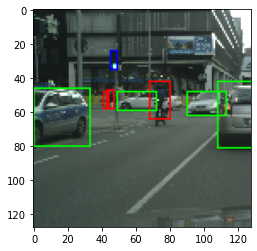

In [15]:
# # Show the chosen image with ground truth bounding boxes visualized.
from copy import deepcopy
# import cv2

def visualise_label(required_label,image):
  
  image=deepcopy(image)
  for row in required_label:
    # break
  
    if(row[0]==0):
      ### red right now,pedestrians
      color = (255, 0, 0)
      cv2.rectangle(image,(int(row[1]),int(row[2])),(int(row[3]),int(row[4])),color)
    
    if(row[0]==1):
      ### blue traffic light
      color = (0, 0, 255)
      # print(row[1])
      cv2.rectangle(image,(int(row[1]),int(row[2])),(int(row[3]),int(row[4])),color)
    if(row[0]==2):
      ### car green
      color = (0, 255, 0)
      # print(row[1])
      cv2.rectangle(image,(int(row[1]),int(row[2])),(int(row[3]),int(row[4])),color)
  plt.imshow(image)
  # plt.title("Ground truth image label visulaization")
  plt.show()

image_id=-1
required_label=0
for idx,label in enumerate(raw_labels):
  # print(np.unique(label[:,0]).shape)
  if(np.unique(label[:,0]).shape[0]==3):
    image_id=idx
    required_label=label
    break


# from google.colab.patches import cv2_imshow
image=images[image_id]
visualise_label(required_label,image)
# plt.imshow(image)
# plt.title("Ground truth image label visulaization")
# plt.show()

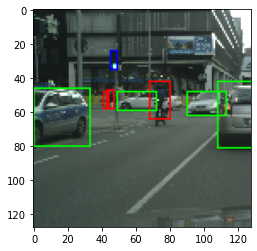

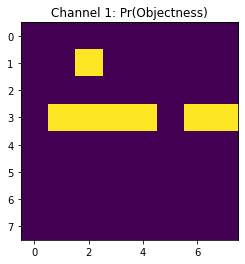

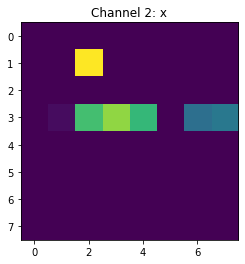

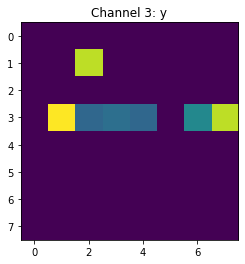

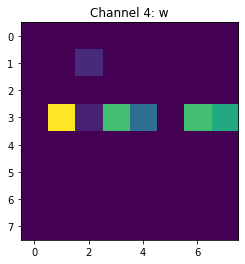

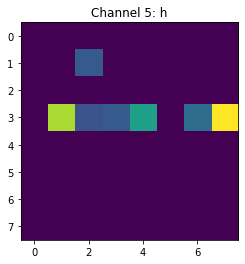

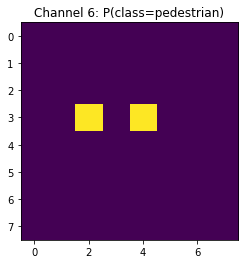

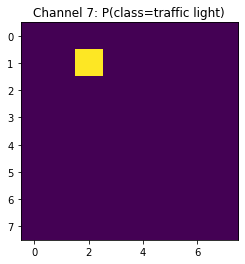

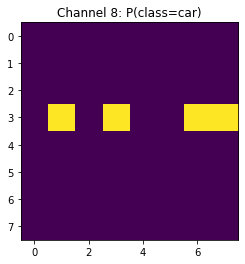

In [ ]:
# Visualize the 8x8x8 representation. 
processed_label=process_labels(required_label)
visualise_label(required_label,images[image_id])
plt.imshow(processed_label[0])
plt.title("Channel 1: Pr(Objectness)")
plt.show()
plt.imshow(processed_label[1])
plt.title("Channel 2: x")
plt.show()
plt.imshow(processed_label[2])
plt.title("Channel 3: y")
plt.show()
plt.imshow(processed_label[3])
plt.title("Channel 4: w")
plt.show()
plt.imshow(processed_label[4])
plt.title("Channel 5: h")
plt.show()
plt.imshow(processed_label[5])
plt.title("Channel 6: P(class=pedestrian)")
plt.show()
plt.imshow(processed_label[6])
plt.title("Channel 7: P(class=traffic light)")
plt.show()
plt.imshow(processed_label[7])
plt.title("Channel 8: P(class=car)")
plt.show()

##Reconstructing the label and visualising it

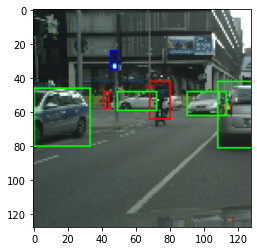

In [ ]:
# Convert back to the original representation (test cases below should pass).
required_label_processed=process_labels(required_label)
recon_required_label=reconstruct_raw_labels(required_label_processed)
image = visualise_label(recon_required_label,images[image_id])
# plt.imshow(image)
# plt.title("Representation of the converted image")
# plt.show()

2. Implement the loss function. (3%):

Ans: The loss function is implemented above in the function named yolo_loss

3. Make block diagram of requested architecture. Label the diagram with the parts of your code which implement each component. Explain any deviations you made from the described architecture. (15%)

Ans: After looking at the labels that we created for the ground truth provided, we see that all the 8 values in the 8 channels of the augmented ground truth are between 0 and 1. To speed up the learning of the network and to take advantage of the labels we created, we added a sigmoid activation after the last convolutional layer. This helped us speed up the training process and gives us better results.

--2022-09-25 14:38:37--  https://drive.google.com/uc?id=1bxG7fGmqf5kxl0osQapPHSwd8wHHGjDe
Resolving drive.google.com (drive.google.com)... 142.250.4.139, 142.250.4.102, 142.250.4.100, ...
Connecting to drive.google.com (drive.google.com)|142.250.4.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-b0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/tp8gfcv1ks4f1q678bd41hktug7qegsj/1664116650000/08420579379459537123/*/1bxG7fGmqf5kxl0osQapPHSwd8wHHGjDe?uuid=21175d4c-0dbb-483f-a84c-6f90ec9a4882 [following]
--2022-09-25 14:38:38--  https://doc-0k-b0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/tp8gfcv1ks4f1q678bd41hktug7qegsj/1664116650000/08420579379459537123/*/1bxG7fGmqf5kxl0osQapPHSwd8wHHGjDe?uuid=21175d4c-0dbb-483f-a84c-6f90ec9a4882
Resolving doc-0k-b0-docs.googleusercontent.com (doc-0k-b0-docs.googleusercontent.com)... 172.217.194.132, 2404:6800:4003:c04::84
Connecting to doc-0k-b0

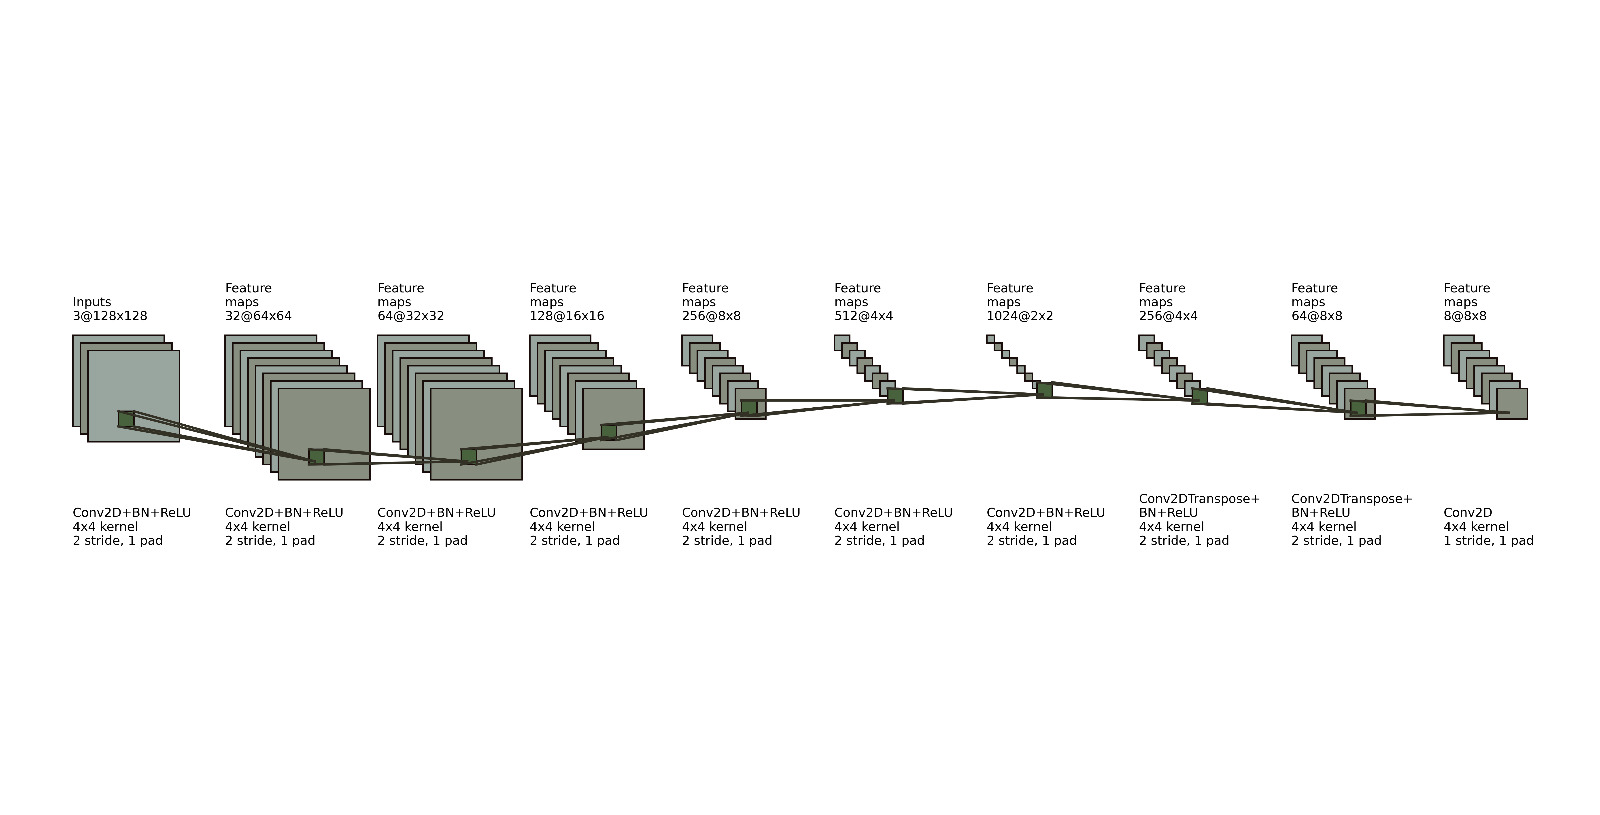

In [ ]:
!wget https://drive.google.com/uc?id=1bxG7fGmqf5kxl0osQapPHSwd8wHHGjDe -O img.jpeg
img=cv2.imread("img.jpeg")
cv2_imshow(img)

4. Show a plot of the loss over training for your model. (Raw Tensorboard output is not sufficient) (10%) 

In [20]:

import torch
# Setup your training
import torch.nn.functional as F
class YOLO(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1=nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, padding=1,stride=2)
      self.bn1=nn.BatchNorm2d(num_features=32)

      self.conv2=nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, padding=1,stride=2)
      self.bn2=nn.BatchNorm2d(num_features=64)

      self.conv3=nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, padding=1,stride=2)
      self.bn3=nn.BatchNorm2d(num_features=128)

      self.conv4=nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, padding=1,stride=2)
      self.bn4=nn.BatchNorm2d(num_features=256)

      self.conv5=nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, padding=1,stride=2)
      self.bn5=nn.BatchNorm2d(num_features=512)

      self.conv6=nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, padding=1,stride=2)
      self.bn6=nn.BatchNorm2d(num_features=1024)

      self.trans_conv1=nn.ConvTranspose2d(in_channels=1024,out_channels=256,kernel_size=4,stride=2,padding=1)
      self.bn7=nn.BatchNorm2d(num_features=256)

      self.trans_conv2=nn.ConvTranspose2d(in_channels=256,out_channels=64,kernel_size=4,stride=2,padding=1)
      self.bn8=nn.BatchNorm2d(num_features=64)

      self.conv9=nn.Conv2d(in_channels=64,out_channels=8,kernel_size=3,stride=1,padding=1)
      self.sigmoid_op=nn.Sigmoid()


    def forward(self, x):
        x=self.bn1(F.relu(self.conv1(x)))
        x=self.bn2(F.relu(self.conv2(x)))
        x=self.bn3(F.relu(self.conv3(x)))
        x=self.bn4(F.relu(self.conv4(x)))
        x=self.bn5(F.relu(self.conv5(x)))
        x=self.bn6(F.relu(self.conv6(x)))

        x=self.bn7(F.relu(self.trans_conv1(x)))
        x=self.bn8(F.relu(self.trans_conv2(x)))

        x=self.conv9(x)
        x=self.sigmoid_op(x)
        # print(x.shape)
        return x
    
    def load_from_url():
      model_url="https://drive.google.com/uc?id=1MBs1aCOlLxaFjjd3F9PLmbJTgEwtGDH4&export=download&confirm=t&uuid=bfd473da-ea55-4e19-aef2-4e385a423405"
      # x=torch.hub.load_state_dict_from_url(model_url,progress=True, map_location='cpu')
      # print(x)
      y = YOLO()
      y.load_state_dict(torch.hub.load_state_dict_from_url(model_url,progress=True, map_location='cpu')['model_state_dict'])
      return y
  
    def inference(self,images, labels):
      # k = YOLO()
      import torch
      with torch.no_grad():
        self.eval()
        
        images=torch.permute(torch.from_numpy(images), (0,3, 2, 1))
        output = self.forward(images.float())
        pred_gradescope = []
        model_preds_after=probability_filtering(output)
        NMS_predictions_with_conf=NMS_model_pred_gradescope(model_preds_after)
        for pred in NMS_predictions_with_conf:
          pred_gradescope.append(pred)

      return pred_gradescope


In [21]:
YOLO.load_from_url()

<All keys matched successfully>

In [ ]:
# m = YOLO().to(device)
# m.load_from_url()

<All keys matched successfully>

In [ ]:
for idx,(images,label) in enumerate(val_dataloader):
  
  images=torch.permute(images, (0,3, 2, 1))
  m.inference(images,label)

In [18]:
processed_labels=np.zeros((raw_labels.shape[0],8,8,8))
for id,label in enumerate(raw_labels):
  processed_labels[id]=process_labels(label)


In [19]:
from torch.utils.data import Dataset, TensorDataset, DataLoader
my_dataset = TensorDataset(torch.from_numpy(images).float(),torch.from_numpy(processed_labels)) # create your datset
train_set,val_set=torch.utils.data.random_split(my_dataset,[9800,100],generator=torch.Generator().manual_seed(42))
train_dataloader = DataLoader(train_set,batch_size=64, shuffle=False)
val_dataloader=DataLoader(val_set,batch_size=16,shuffle=False)

In [20]:
from tqdm import tqdm
def validation(model,val_dataloader):
  with torch.no_grad():

    batch_count=0
    val_loss=0
    for idx,(images,label) in tqdm(enumerate(val_dataloader)):
      images=torch.permute(images, (0,3, 2, 1))
      pred=model(images.to(device))
      loss=yolo_loss(pred,label.to(device))
      val_loss+=loss.item()/images.shape[0]
      batch_count+=1
    
  val_loss_per_epoch=val_loss/batch_count
  return val_loss_per_epoch

In [21]:
def make_data(model, val_dataloader):
  pred_list=[]
  gt_labels=[]
  for idx,(images,label) in enumerate(val_dataloader):
    images=torch.permute(images, (0,3, 2, 1))
    pred=model(images.to(device)).cpu().detach()
    # print(pred.shape)
    model_preds_after=probability_filtering(pred)
    # print(model_preds_after.shape)
    NMS_predictions_with_conf=NMS_model_pred_gradescope(model_preds_after)
    for pred_label in NMS_predictions_with_conf:
      pred_list.append(pred_label)
    for label_processed in label:
      gt_labels.append(reconstruct_raw_labels(label_processed.numpy()))
  return pred_list , gt_labels

In [24]:
def cal_map(pred_arr, gt_arr, iou_thresh = 0.5, num_class = 3):
  epsilon = 1e-6
  tp_list = []
  fp_list = []
  p_list = []
  for c in range(num_class):
    c_pred = torch.from_numpy(pred_arr[pred_arr[:,0]==c]) #only indices where there is actually the label of int
    c_pred = c_pred[torch.argsort(c_pred[:,1], descending = True)]
    c_gt = torch.from_numpy(gt_arr[gt_arr[:,0]==c])
    # print(c_gt.shape[0])
    total_gt_boxes = c_gt.shape[0]
    is_gtbbox_taken = torch.zeros(c_gt.shape[0]) #keep track if that gt bbox has been taken as a TP by some more confident pred bbox
    TP = torch.zeros(c_pred.shape[0]) #for one class this is 
    FP = torch.zeros(c_pred.shape[0])
    P = torch.zeros(c_pred.shape[0])
  
    for pred_bbox_idx, pred_bbox in enumerate(c_pred): #take sorted pred bboxes and check for the highest IOU with the ALL gt bboxes
      best_iou = 0
      best_idx = 0
      P[pred_bbox_idx] = pred_bbox[1]
      for gt_box_idx, gt_box in enumerate(c_gt):
        # print(pred_bbox)
        p_box = torch.reshape(pred_bbox[2:], (1, pred_bbox[2:].shape[0]))
        g_box = torch.reshape(gt_box[1:], (1, gt_box[1:].shape[0]))
        # print(g_box.shape)
        iou = torchvision.ops.box_iou(p_box, g_box)
        if(iou > best_iou):
          best_iou = iou
          best_idx = gt_box_idx
      if(best_iou > iou_thresh): #forr this pred bbox, found the best matching gt bbox and now seeing if its taken or not
        if(is_gtbbox_taken[best_idx] ==0): #NOT TAKEN
          TP[pred_bbox_idx] = 1
          is_gtbbox_taken[best_idx] = 1
        else: #TAKEN LOL
          # FP[pred_bbox_idx] = 1
          TP[pred_bbox_idx] = 1
      else: #iou was not enough
        FP[pred_bbox_idx] = 1
    tp_list.append(TP)
    fp_list.append(FP)
    p_list.append(P)
    # print(TP)
    # TP_cumsum = torch.cumsum(TP, dim=0)
    # FP_cumsum = torch.cumsum(FP, dim=0)
    # recalls = TP_cumsum/ (total_gt_boxes + epsilon)
    # precision = TP_cumsum/ (TP_cumsum + FP_cumsum + epsilon)
    # ap_class = torch.trapz(precision, recalls)
    # ap_class_list.append(ap_class)
  return tp_list, fp_list, p_list

In [27]:
# from sklearn import metrics
def find_map(pred_list, gt_labels):
  # class_0 = []
  gt_c0 = 0
  gt_c1 = 0
  gt_c2 = 0
  for image_idx, image in enumerate(pred_list):
    gt_img = gt_labels[image_idx]
    gt_c0 += gt_img[gt_img[:,0]==0].shape[0]
    gt_c1 += gt_img[gt_img[:,0]==1].shape[0]
    gt_c2 += gt_img[gt_img[:,0]==2].shape[0]

    # c0 = np.concatenate(c0, image[np.where(image[:,0] == 0)])
    tp,fp,p = cal_map(image, gt_img)
    if(image_idx ==0):
      c0_tp = tp[0]


      c0_fp = fp[0]
      # print(tp[0])
      # print(fp[0])
      # print(torch.cat((tp[0], fp[0])).shape)
      # break
      c0_p = p[0]
      c1_tp = tp[1]
      c1_fp = fp[1]
      c1_p = p[1]
      c2_tp = tp[2]
      c2_fp = fp[2]
      c2_p = p[2]

      
    else:
      c0_tp = torch.cat((c0_tp, tp[0]))
      # print(c0_tp)
      c0_fp = torch.cat((c0_fp, fp[0]))
      c0_p = torch.cat((c0_p, p[0]))
      c1_tp = torch.cat((c1_tp, tp[1]))
      c1_fp = torch.cat((c1_fp, fp[1]))
      c1_p = torch.cat((c1_p, p[1]))
      c2_tp = torch.cat((c2_tp, tp[2]))
      c2_fp = torch.cat((c2_fp, fp[2]))
      c2_p = torch.cat((c2_p, p[2]))

  # iter = np.arange(0.6,1, 0.005)[::-1]
  p_list0 = []
  p_list1 = []
  p_list2 = []
  r_list0 = []
  r_list1 = []
  r_list2 = []
  eps= 1e-6
  for i in c0_p:
    TP_c0 = torch.sum(c0_tp[torch.where(c0_p>i)[0]]).cpu().detach().numpy()
    FP_c0 = torch.sum(c0_fp[torch.where(c0_p>i)[0]]).cpu().detach().numpy()

    p_list0.append(TP_c0/(TP_c0+ FP_c0 + eps))
    r_list0.append(TP_c0/gt_c0)

  for i in c1_p:
    TP_c1 = torch.sum(c1_tp[torch.where(c1_p>i)[0]]).cpu().detach().numpy()
    FP_c1 = torch.sum(c1_fp[torch.where(c1_p>i)[0]]).cpu().detach().numpy()

    p_list1.append(TP_c1/(TP_c1+ FP_c1 + eps))
    r_list1.append(TP_c1/gt_c1)

  for i in c2_p:
    TP_c2 = torch.sum(c2_tp[torch.where(c2_p>i)[0]]).cpu().detach().numpy()
    FP_c2 = torch.sum(c2_fp[torch.where(c2_p>i)[0]]).cpu().detach().numpy()

    p_list2.append(TP_c2/(TP_c2+ FP_c2 + eps))
    r_list2.append(TP_c2/gt_c2)

  p_list0 = np.array(p_list0)
  # p_list0 = np.concatenate((np.array([1]),p_list0))
  p_list1 = np.array(p_list1)
  # p_list1 = np.concatenate((np.array([1]),p_list1))
  p_list2 = np.array(p_list2)
  # p_list2 = np.concatenate((np.array([1]),p_list2))

  r_list0 = np.array(r_list0)
  # r_list0 = np.concatenate((np.array([0]),r_list0))
  r_list1 = np.array(r_list1)
  # r_list1 = np.concatenate((np.array([0]),r_list1))
  r_list2 = np.array(r_list2)
  # r_list2 = np.concatenate((np.array([0]),r_list2))

  if(r_list0.shape[0]>1):
    AP0 = metrics.auc(r_list0[np.argsort(r_list0)], p_list0[np.argsort(r_list0)])
  else:
    AP0=0
  if(r_list1.shape[0]>1):
    AP1 = metrics.auc(r_list1[np.argsort(r_list1)], p_list1[np.argsort(r_list1)])
  else:
    AP1=0

  if(r_list2.shape[0]>1):
    AP2 = metrics.auc(r_list2[np.argsort(r_list2)], p_list2[np.argsort(r_list2)])
  else:
    AP2=0
  
  print(AP0)
  print(AP1)
  print(AP2)
  # AP_sum+=AP
  # plt.plot(r_list0[np.argsort(r_list0)], p_list0[np.argsort(r_list0)])
  # plt.show()
  # plt.plot(r_list1[np.argsort(r_list1)], p_list1[np.argsort(r_list1)])
  # plt.show()

  # plt.plot(r_list2[np.argsort(r_list2)], p_list2[np.argsort(r_list2)])
  # plt.show()
  return (AP0 + AP1 + AP2)/3

154it [00:17,  9.00it/s]


Epoch: 0
loss per epoch: 7.330240083941998


7it [00:00, 111.36it/s]


The validation loss is  5.915511974852769
0.003897283776687102
0
0.02223071164553301
0.008709331807406703


154it [00:17,  8.96it/s]


Epoch: 1
loss per epoch: 5.358887946885703


7it [00:00, 121.34it/s]


The validation loss is  4.968519263170404
0.0007291006427642727
0
0.04583284502824708
0.015520648557003787


154it [00:17,  8.87it/s]


Epoch: 2
loss per epoch: 4.367769212036852


7it [00:00, 108.87it/s]


The validation loss is  4.496046659497397
0.0030607281006072057
0
0.05833249220685373
0.020464406769153645


154it [00:17,  8.71it/s]


Epoch: 3
loss per epoch: 3.667341577207217


7it [00:00, 110.83it/s]


The validation loss is  4.406757003863961
0.00457479389332976
0
0.06813706492873456
0.02423728627402144


154it [00:17,  8.60it/s]


Epoch: 4
loss per epoch: 3.0109731404214806


7it [00:00, 115.18it/s]


The validation loss is  4.17515886088564
0.006212585592405686
0.0
0.12751058838697454
0.04457439132646007


154it [00:17,  8.62it/s]


Epoch: 5
loss per epoch: 2.4011392669417226


7it [00:00, 109.03it/s]


The validation loss is  4.081027288480422
0.028141186253916012
0.0
0.1167844740369223
0.048308553430279434


154it [00:17,  8.71it/s]


Epoch: 6
loss per epoch: 1.8880441094124367


7it [00:00, 113.65it/s]


The validation loss is  4.181466026781498
0.03441307818841806
0.0
0.14088865458460542
0.05843391092434116


154it [00:17,  8.73it/s]


Epoch: 7
loss per epoch: 1.4335687695879782


7it [00:00, 108.59it/s]


The validation loss is  3.950772714423716
0.040433664849128095
0.0
0.16452928500229086
0.06832098328380631


154it [00:17,  8.71it/s]


Epoch: 8
loss per epoch: 1.0871655559573394


7it [00:00, 115.56it/s]


The validation loss is  3.9985936694734057
0.05845248726887352
0.01851850000001852
0.1590930699308885
0.07868801906659352


154it [00:17,  8.69it/s]


Epoch: 9
loss per epoch: 0.867381715471533


7it [00:00, 127.49it/s]


The validation loss is  3.694747907411738
0.035998314842067516
0.016666662870371246
0.08897602210413168
0.04721366660552348


154it [00:17,  8.68it/s]


Epoch: 10
loss per epoch: 0.7141804372518992


7it [00:00, 123.18it/s]


The validation loss is  3.805283844729011
0.058120559387208996
0.0026455022675737497
0.08513594953921191
0.04863400373133155


154it [00:17,  8.71it/s]


Epoch: 11
loss per epoch: 0.6062015113531607


7it [00:00, 117.35it/s]


The validation loss is  3.6016612119635694
0.03761092080507865
0.013651468550631667
0.12544088251986144
0.05890109062519058


154it [00:17,  8.69it/s]


Epoch: 12
loss per epoch: 0.5121447591003963


7it [00:00, 134.96it/s]


The validation loss is  3.5562970926100452
0.09743827987315769
0.0207230966133398
0.20091357830027085
0.10635831826225611


154it [00:17,  8.69it/s]


Epoch: 13
loss per epoch: 0.4360466213627461


7it [00:00, 121.08it/s]


The validation loss is  3.6195379563897854
0.048349416789154595
0.01756114059175888
0.18917764619226213
0.08502940119105855


154it [00:17,  8.71it/s]


Epoch: 14
loss per epoch: 0.3827481776034984


7it [00:00, 116.53it/s]


The validation loss is  3.3949300425435758
0.06353295826987186
0.022422635863309594
0.2140227159792682
0.09999277003748323


154it [00:17,  8.71it/s]


Epoch: 15
loss per epoch: 0.3416664487284436


7it [00:00, 118.76it/s]


The validation loss is  3.3743348006316913
0.07170197978682381
0.025815692514829146
0.23690684692457123
0.11147483974207473


154it [00:17,  8.71it/s]


Epoch: 16
loss per epoch: 0.31975496593751834


7it [00:00, 104.86it/s]


The validation loss is  3.252038072607501
0.09975813936995973
0.04363074200992444
0.1806352730180574
0.10800805146598053


154it [00:17,  8.68it/s]


Epoch: 17
loss per epoch: 0.30346938118678224


7it [00:00, 115.67it/s]


The validation loss is  3.329611617945459
0.09847730926328849
0.029012340168039528
0.2203585206461568
0.11594939002582827


154it [00:17,  8.71it/s]


Epoch: 18
loss per epoch: 0.28992705407934716


7it [00:00, 119.34it/s]


The validation loss is  3.447256698794086
0.08636445877817418
0.002314814525462999
0.21072417356943507
0.09980114895769075


154it [00:17,  8.68it/s]


Epoch: 19
loss per epoch: 0.2687775612709222


7it [00:00, 121.72it/s]


The validation loss is  3.367832988558745
0.09503120770076526
0.029012339567902713
0.1758527157769832
0.09996542101521705


154it [00:17,  8.67it/s]


Epoch: 20
loss per epoch: 0.2604635739787877


7it [00:00, 117.57it/s]


The validation loss is  3.2184013713163204
0.14409629059720946
0.004629628472222511
0.18418837558441417
0.11097143155128204


154it [00:17,  8.67it/s]


Epoch: 21
loss per epoch: 0.24486637173004924


7it [00:00, 124.87it/s]


The validation loss is  3.2610909332013933
0.1043297803664926
0.017740975566127564
0.16799311353251417
0.09668795648837812


154it [00:17,  8.69it/s]


Epoch: 22
loss per epoch: 0.23329671593361614


7it [00:00, 119.74it/s]


The validation loss is  3.1076943357872073
0.1713538121657326
0.01851850000001852
0.2773684470858333
0.15574691975052815


154it [00:17,  8.71it/s]


Epoch: 23
loss per epoch: 0.21706503106009567


7it [00:00, 116.71it/s]


The validation loss is  3.2156144518164163
0.10615830143888094
0.010157125262558504
0.21065123086701948
0.10898888585615298


154it [00:17,  8.70it/s]


Epoch: 24
loss per epoch: 0.2184885804353541


7it [00:00, 114.11it/s]


The validation loss is  3.2465484984490254
0.09907703532154125
0.044444420672173385
0.23151159131239799
0.12501101576870421


154it [00:17,  8.74it/s]


Epoch: 25
loss per epoch: 0.21686038010406458


7it [00:00, 120.94it/s]


The validation loss is  3.1691229972641985
0.04552686816408602
0.027469130591564864
0.1251558838871181
0.06605062754758965


154it [00:17,  8.70it/s]


Epoch: 26
loss per epoch: 0.2165493668654604


7it [00:00, 113.77it/s]


The validation loss is  3.197236589222863
0.06226823028671115
0.0771604597428219
0.09444936370824814
0.07795935124592707


154it [00:17,  8.68it/s]


Epoch: 27
loss per epoch: 0.21633119618668192


7it [00:00, 110.94it/s]


The validation loss is  3.3333465400280238
0.13801338407671654
0.05874016455418503
0.20909021772159375
0.13528125545083178


154it [00:17,  8.69it/s]


Epoch: 28
loss per epoch: 0.23074132732124328


7it [00:00, 114.34it/s]


The validation loss is  3.341124729594187
0.07934733143094688
0.0382715937688654
0.19527461146890218
0.10429784555623815


154it [00:17,  8.69it/s]


Epoch: 29
loss per epoch: 0.2686871986343438


7it [00:00, 125.87it/s]


The validation loss is  3.4059037150222577
0.050140158553915244
0.008140007164996299
0.1828506434625014
0.08037693639380432


154it [00:17,  8.72it/s]


Epoch: 30
loss per epoch: 0.5303800098542604


7it [00:00, 101.99it/s]


The validation loss is  4.231121687378196
0.03513356479119103
0.00748222894111342
0.12412129972136651
0.05557903115122365


154it [00:17,  8.72it/s]


Epoch: 31
loss per epoch: 1.0785296350599667


7it [00:00, 115.78it/s]


The validation loss is  3.5273183692382126
0.012436369307677766
0.019723689405491296
0.18790645249387372
0.07335550373568094


154it [00:17,  8.73it/s]


Epoch: 32
loss per epoch: 0.6348972880442476


7it [00:00, 109.88it/s]


The validation loss is  3.4351974330566564
0.07792013654422401
0.03350969624048227
0.17664821890413387
0.09602601722961339


154it [00:17,  8.74it/s]


Epoch: 33
loss per epoch: 0.33446743670685136


7it [00:00, 109.31it/s]


The validation loss is  3.2364725992435472
0.06102568141140784
0.05351163064879223
0.24257015384149086
0.11903582196723032


154it [00:17,  8.71it/s]


Epoch: 34
loss per epoch: 0.1960071068851305


7it [00:00, 115.88it/s]


The validation loss is  3.2911784367441537
0.07589614066428232
0.0566798695244504
0.20043407753777648
0.11100336257550307


154it [00:17,  8.73it/s]


Epoch: 35
loss per epoch: 0.14675152517264853


7it [00:00, 125.25it/s]


The validation loss is  3.1851588218420384
0.096239738809124
0.10253856473816117
0.2064696469550112
0.13508265016743212


154it [00:17,  8.71it/s]


Epoch: 36
loss per epoch: 0.14925022440731187


7it [00:00, 111.32it/s]


The validation loss is  3.2791458321881044
0.06381883494337365
0.0975308276131926
0.19674189199500328
0.11936385151718983


154it [00:17,  8.69it/s]


Epoch: 37
loss per epoch: 0.18512908211231577


7it [00:00, 111.67it/s]


The validation loss is  3.2813781601930923
0.13351731629032318
0.09689483710818053
0.2331743605818543
0.15452883799345266


154it [00:17,  8.69it/s]


Epoch: 38
loss per epoch: 0.18580940027437434


7it [00:00, 106.07it/s]


The validation loss is  3.117692830575464
0.108044555684395
0.04826036990344347
0.26074104331553116
0.13901532296778987


154it [00:17,  8.70it/s]


Epoch: 39
loss per epoch: 0.1508470680990951


7it [00:00, 121.19it/s]


The validation loss is  3.1050154050585137
0.09122098380235479
0.01499117639309049
0.17031393004849388
0.09217536341464638


154it [00:17,  8.71it/s]


Epoch: 40
loss per epoch: 0.12807499818705328


7it [00:00, 107.44it/s]


The validation loss is  3.145755780945938
0.06645479627900683
0.04821427634619035
0.1354947604641361
0.0833879443631111


154it [00:17,  8.71it/s]


Epoch: 41
loss per epoch: 0.12019573988056646


7it [00:00, 112.61it/s]


The validation loss is  3.116963725070051
0.09162230790283013
0.17553305591887527
0.22684169954692587
0.16466568778954374


154it [00:17,  8.73it/s]


Epoch: 42
loss per epoch: 0.11327407287851823


7it [00:00, 123.24it/s]


The validation loss is  3.1714213464879606
0.143238838906806
0.04949492209138998
0.19325593732781263
0.1286632327753362


154it [00:17,  8.69it/s]


Epoch: 43
loss per epoch: 0.10455444743955067


7it [00:00, 123.07it/s]


The validation loss is  3.0546642355274054
0.1484378350228403
0.0777630649613592
0.25377152629881755
0.1599908087610057


154it [00:17,  8.71it/s]


Epoch: 44
loss per epoch: 0.1012284928160764


7it [00:00, 128.00it/s]


The validation loss is  3.1305105699158537
0.11228396507778364
0.019527281028752473
0.19039678465265295
0.10740267691972967


154it [00:17,  8.70it/s]


Epoch: 45
loss per epoch: 0.09993022520895761


7it [00:00, 123.54it/s]


The validation loss is  3.1333252858810456
0.07245739940153595
0.04408829355127588
0.1819247452334982
0.09949014606210334


154it [00:17,  8.72it/s]


Epoch: 46
loss per epoch: 0.10359416040767928


7it [00:00, 117.40it/s]


The validation loss is  3.0747698942584103
0.06460040037475034
0.060732313706380305
0.1879877662169085
0.10444016009934638


154it [00:17,  8.69it/s]


Epoch: 47
loss per epoch: 0.1132456491124134


7it [00:00, 118.29it/s]


The validation loss is  3.0878760698973435
0.1099042811861886
0.04597130753530482
0.19671493199677365
0.11753017357275569


154it [00:17,  8.71it/s]


Epoch: 48
loss per epoch: 0.12645003443118974


7it [00:00, 109.45it/s]


The validation loss is  3.09978808436358
0.11948416577810718
0.04403661741618895
0.2514612908156777
0.1383273580033246


154it [00:17,  8.72it/s]


Epoch: 49
loss per epoch: 0.14355581158798872


7it [00:00, 114.78it/s]


The validation loss is  3.3678617369808213
0.0793077002950929
0.009920633196334445
0.2443997427673247
0.11120935875291736


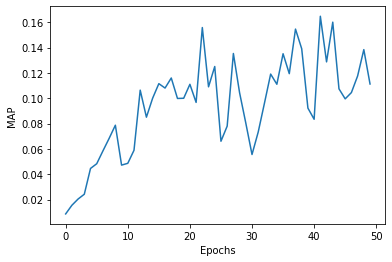

In [28]:
from tqdm import tqdm
# Train your model
model=YOLO().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.97)
num_epochs=50
train_loss_list=[]
val_loss_list=[]
map_list = []
for epoch in range(num_epochs):
  number=0
  accuracy=0
  train_loss=0
  batch_count=0
  for idx,(images,label) in tqdm(enumerate(train_dataloader)):

    images=torch.permute(images, (0,3, 2, 1))
    pred=model(images.to(device))

    loss = yolo_loss(pred,label.to(device))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

    train_loss+=loss.item()/images.shape[0]
    batch_count+=1
  # scheduler.step()
  loss_per_epoch=train_loss/batch_count
  train_loss_list.append(loss_per_epoch)
  print("Epoch:",epoch)
  print("loss per epoch:",loss_per_epoch)
  val_loss=validation(model,val_dataloader)
  print("The validation loss is ",val_loss)
  val_loss_list.append(val_loss)
  pred_list, gt_labels = make_data(model, val_dataloader)
  map = find_map(pred_list, gt_labels)
  map_list.append(map)
  print(map)

plt.plot(map_list)
plt.xlabel("Epochs")
plt.ylabel("MAP")
plt.show()


Text(0, 0.5, 'Training loss')

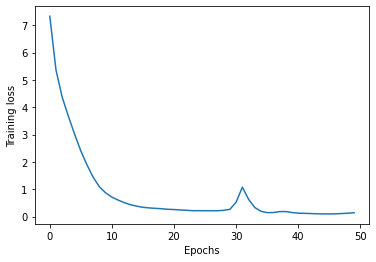

In [29]:
# Plot the results
plt.plot(train_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Training loss")

Text(0, 0.5, 'Validation loss')

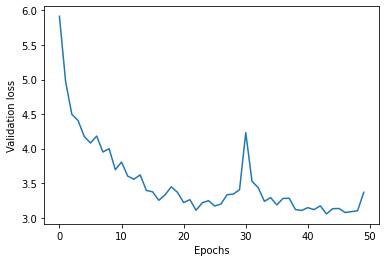

In [30]:
plt.plot(val_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Validation loss")

In [ ]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            },"/content/drive/MyDrive/CIS680/model_divyanshu.pth")

## Loading model

0

In [ ]:
model=YOLO().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/CIS680/model_diff_loss.pth')['model_state_dict'])
# model.load_state_dict(torch.load('https://github.com/divyanshurs/model_weights/raw/master/model.pth')['model_state_dict'])
# model.load_state_dict(torch.load('/content/drive/MyDrive/CIS680/model_diff_loss_50_new_with_lr.pth',map_location=torch.device(device))['model_state_dict'])
model.eval()

# <a data-permalink-href="/divyanshurs/model_weights/raw/b83a09ab9a9e3ce354e703473e91df46df073946/model.pth" href="/divyanshurs/model_weights/raw/master/model.pth" id="raw-url" data-view-component="true" class="js-permalink-replaceable-link btn-sm btn BtnGroup-item">    Download
# </a>

YOLO(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn6): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [ ]:
def load_data(file_name):
    return np.load(file_name, allow_pickle=True, encoding='latin1')['arr_0']

images = load_data('/content/drive/MyDrive/CIS680/images.npz')
raw_labels = load_data('/content/drive/MyDrive/CIS680/labels.npz')

5. Show a plot of the mean Average Precision over training for your model. (10%)

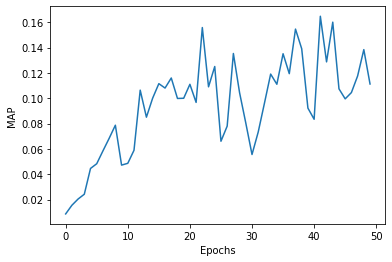

In [31]:
plt.plot(map_list)
plt.xlabel("Epochs")
plt.ylabel("MAP")
plt.show()

6. For one image in the inference step, show the predicted bounding boxes in the image before performing any elimination. Then, show the annotated image after the low probability bounding boxes are removed. Finally, show image after performing non-max suppression. Label each of these visualizations. See Figure 4 as an example of what this visualization should look like. (15%)

##Real Label

In [ ]:
from copy import deepcopy
image_torch=torch.from_numpy(deepcopy(images[7:8]))
image_transformed=torch.permute(image_torch, (0,3, 2, 1))
model_predictions=model(image_transformed.to(device).float()).cpu().detach()


gt_labels=deepcopy(raw_labels[7:8])
test_images=deepcopy(images[7:8])

In [ ]:
def visualise_label_gradescope(required_label,image):
  
  image=deepcopy(image)
  for row in required_label:
    # break
  
    if(row[0]==0):
      ### red right now,pedestrians
      color = (255, 0, 0)
      cv2.rectangle(image,(int(row[1]),int(row[2])),(int(row[3]),int(row[4])),color)
    
    if(row[0]==1):
      ### blue traffic light
      color = (0, 0, 255)
      # print(row[1])
      cv2.rectangle(image,(int(row[1]),int(row[2])),(int(row[3]),int(row[4])),color)
    if(row[0]==2):
      ### car green
      color = (0, 255, 0)
      # print(row[1])
      cv2.rectangle(image,(int(row[1]),int(row[2])),(int(row[3]),int(row[4])),color)
  return image

In [ ]:
for i in np.arange(7,8):
  image_real=visualise_label_gradescope(reconstruct_raw_labels(process_labels(gt_labels[i-7])),test_images[i-7])

## Model predictions wihtout probability filtering

In [ ]:
without_probability_filtering=reconstruct_model_pred_to_bbox(model_predictions)
for j in np.arange(7,8):
  image_without_probability_filtering=visualise_label_gradescope(without_probability_filtering[j-7],test_images[j-7])

## After probability filtering

In [ ]:
model_preds_after=probability_filtering(model_predictions)
after_probability_filtering=reconstruct_model_pred_to_bbox(model_preds_after)
for j in np.arange(7,8):
  image_after_probability_filtering=visualise_label_gradescope(after_probability_filtering[j-7],test_images[j-7])

## After NMS

In [ ]:
model_preds_after=probability_filtering(model_predictions)
NMS_predictions=NMS_model_pred(model_preds_after)
for j in np.arange(7,8):
  image_after_nms=visualise_label_gradescope(NMS_predictions[j-7],test_images[j-7])

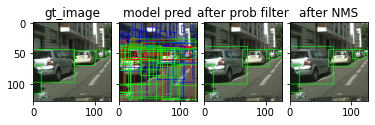

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure()
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im,title in zip(grid, [image_real,image_without_probability_filtering, image_after_probability_filtering, image_after_nms],["gt_image","model pred","after prob filter","after NMS"]):
    # Iterating over the grid returns the Axes.
   
    ax.set_title(title)
    ax.imshow(im)

plt.show()

7. For one image in the inference step, show the bounding boxes visualized for each class with green bounding boxes around cars, red bounding boxes around pedestrians, and blue bounding boxes around traffic lights as done in Figure 1. Show the precision/recall curves for each class in inference. Write down the achieved mean Average Precision for your inference stage. (17%)

ANS: As seen from the plots below, MAP achieved in inference is  0.30119158023103076

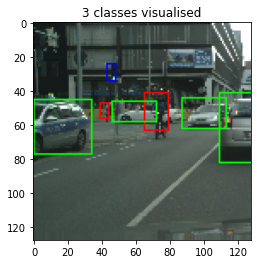

In [ ]:
from copy import deepcopy
image_torch=torch.from_numpy(deepcopy(images[8:9]))
image_transformed=torch.permute(image_torch, (0,3, 2, 1))
model_predictions=model(image_transformed.to(device).float()).cpu().detach()


gt_labels=deepcopy(raw_labels[8:9])
test_images=deepcopy(images[8:9])

# model_preds_after=probability_filtering(model_predictions)
model_preds_after=probability_filtering(model_predictions)
model_pred_bbox=reconstruct_model_pred_to_bbox(model_preds_after)
for i in range(test_images.shape[0]):
  image_3_classes=visualise_label_gradescope(model_pred_bbox[i],test_images[i])
plt.imshow(image_3_classes)
plt.title("3 classes visualised")
plt.show()

## For yolo evaluation

In [ ]:
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
processed_labels=np.zeros((raw_labels.shape[0],8,8,8))
for id,label in enumerate(raw_labels):
  processed_labels[id]=process_labels(label)

In [ ]:
my_dataset = TensorDataset(torch.from_numpy(images).float(),torch.from_numpy(processed_labels)) # create your datset
train_set,val_set=torch.utils.data.random_split(my_dataset,[9800,100],generator=torch.Generator().manual_seed(42))
train_dataloader = DataLoader(train_set,batch_size=128, shuffle=False)
val_dataloader=DataLoader(val_set,batch_size=10,shuffle=False)

In [ ]:
val_dataset_mine = TensorDataset(torch.from_numpy(images[300:400]).float(),torch.from_numpy(processed_labels[300:400])) # create your datset
val_dataloader_mine=DataLoader(val_dataset_mine,batch_size=10,shuffle=False)

In [ ]:
pred_list=[]
gt_labels=[]
for idx,(images,label) in enumerate(val_dataloader_mine):
  
  images=torch.permute(images, (0,3, 2, 1))
  pred=model(images.to(device)).cpu().detach()
  # print(pred.shape)
  model_preds_after=probability_filtering(pred)
  # print(model_preds_after.shape)
  NMS_predictions_with_conf=NMS_model_pred_gradescope(model_preds_after)
  for pred_label in NMS_predictions_with_conf:
    pred_list.append(pred_label)
  for label_processed in label:
    gt_labels.append(reconstruct_raw_labels(label_processed.numpy()))

In [ ]:
def map_plot(pred_list, gt_labels):
  # class_0 = []
  gt_c0 = 0
  gt_c1 = 0
  gt_c2 = 0
  for image_idx, image in enumerate(pred_list):
    gt_img = gt_labels[image_idx]
    gt_c0 += gt_img[gt_img[:,0]==0].shape[0]
    gt_c1 += gt_img[gt_img[:,0]==1].shape[0]
    gt_c2 += gt_img[gt_img[:,0]==2].shape[0]

    # c0 = np.concatenate(c0, image[np.where(image[:,0] == 0)])
    tp,fp,p = cal_map(image, gt_img)
    if(image_idx ==0):
      c0_tp = tp[0]


      c0_fp = fp[0]
      # print(tp[0])
      # print(fp[0])
      # print(torch.cat((tp[0], fp[0])).shape)
      # break
      c0_p = p[0]
      c1_tp = tp[1]
      c1_fp = fp[1]
      c1_p = p[1]
      c2_tp = tp[2]
      c2_fp = fp[2]
      c2_p = p[2]

      
    else:
      c0_tp = torch.cat((c0_tp, tp[0]))
      # print(c0_tp)
      c0_fp = torch.cat((c0_fp, fp[0]))
      c0_p = torch.cat((c0_p, p[0]))
      c1_tp = torch.cat((c1_tp, tp[1]))
      c1_fp = torch.cat((c1_fp, fp[1]))
      c1_p = torch.cat((c1_p, p[1]))
      c2_tp = torch.cat((c2_tp, tp[2]))
      c2_fp = torch.cat((c2_fp, fp[2]))
      c2_p = torch.cat((c2_p, p[2]))

  # iter = np.arange(0.6,1, 0.005)[::-1]
  p_list0 = []
  p_list1 = []
  p_list2 = []
  r_list0 = []
  r_list1 = []
  r_list2 = []
  eps= 1e-6
  for i in c0_p:
    TP_c0 = torch.sum(c0_tp[torch.where(c0_p>i)[0]]).cpu().detach().numpy()
    FP_c0 = torch.sum(c0_fp[torch.where(c0_p>i)[0]]).cpu().detach().numpy()

    p_list0.append(TP_c0/(TP_c0+ FP_c0 + eps))
    r_list0.append(TP_c0/gt_c0)

  for i in c1_p:
    TP_c1 = torch.sum(c1_tp[torch.where(c1_p>i)[0]]).cpu().detach().numpy()
    FP_c1 = torch.sum(c1_fp[torch.where(c1_p>i)[0]]).cpu().detach().numpy()

    p_list1.append(TP_c1/(TP_c1+ FP_c1 + eps))
    r_list1.append(TP_c1/gt_c1)

  for i in c2_p:
    TP_c2 = torch.sum(c2_tp[torch.where(c2_p>i)[0]]).cpu().detach().numpy()
    FP_c2 = torch.sum(c2_fp[torch.where(c2_p>i)[0]]).cpu().detach().numpy()

    p_list2.append(TP_c2/(TP_c2+ FP_c2 + eps))
    r_list2.append(TP_c2/gt_c2)

  p_list0 = np.array(p_list0)
  # p_list0 = np.concatenate((np.array([1]),p_list0))
  p_list1 = np.array(p_list1)
  # p_list1 = np.concatenate((np.array([1]),p_list1))
  p_list2 = np.array(p_list2)
  # p_list2 = np.concatenate((np.array([1]),p_list2))

  r_list0 = np.array(r_list0)
  # r_list0 = np.concatenate((np.array([0]),r_list0))
  r_list1 = np.array(r_list1)
  # r_list1 = np.concatenate((np.array([0]),r_list1))
  r_list2 = np.array(r_list2)
  # r_list2 = np.concatenate((np.array([0]),r_list2))

  if(r_list0.shape[0]!=1):
    AP0 = metrics.auc(r_list0[np.argsort(r_list0)], p_list0[np.argsort(r_list0)])
  else:
    AP0=0
  if(r_list1.shape[0]!=1):
    AP1 = metrics.auc(r_list1[np.argsort(r_list1)], p_list1[np.argsort(r_list1)])
  else:
    AP1=0

  if(r_list2.shape[0]!=1):
    AP2 = metrics.auc(r_list2[np.argsort(r_list2)], p_list2[np.argsort(r_list2)])
  else:
    AP2=0
  
  # AP_sum+=AP
  plt.plot(r_list0[np.argsort(r_list0)], p_list0[np.argsort(r_list0)])
  plt.xlabel("Recall Class 0")
  plt.ylabel("Precision Class 0")
  plt.show()
  plt.plot(r_list1[np.argsort(r_list1)], p_list1[np.argsort(r_list1)])
  plt.xlabel("Recall Class 1")
  plt.ylabel("Precision Class 1")
  plt.show()
  plt.plot(r_list2[np.argsort(r_list2)], p_list2[np.argsort(r_list2)])
  plt.xlabel("Recall Class 2")
  plt.ylabel("Precision Class 2")
  plt.show()
  print("MAP achieved in inference is ", (AP0 + AP1 + AP2)/3)
  # return (AP0 + AP1 + AP2)/3

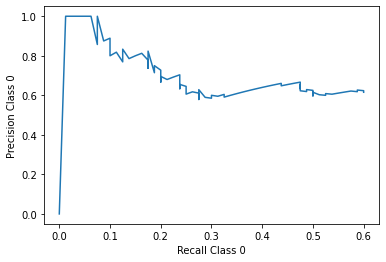

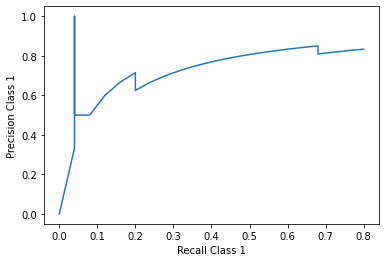

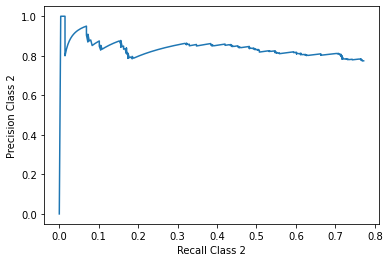

MAP achieved in inference is  0.5454404649728539


In [ ]:
map_plot(pred_list, gt_labels)

## Saving for gradescope

In [ ]:
val_indices=np.arange(300,400).tolist()
pred_gradescope=[]
for i in range(raw_labels.shape[0]):
  if(i in val_indices):
    pred_gradescope.append(pred_list[i-300])
    # print(i)
  else:
    pred_gradescope.append(None)

In [ ]:
np.savez("gradescope.npz",pred_gradescope)

/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


## Pred list is a list with (class_label,confidence_score,x1,y1,x2,x2) for each image

8. Explain any issues or challenges you had with your implementation. Explain the performance you achieved and any interesting observations you made while training your network. Discuss hypotheses for how you could improve the performance of your implementation further. (20%)

Ans: The main challenge we faced was mostly related to code book keeping which mainly pertained to the pre and post processing dimensions of the network.

As can be seen from our plots, we achieved an MAP of 0.5 which is close to the gradescope predictions and also as can be seen from the individual precision recall curves, we are able to detect all the classes. We observed that the network was having a hard time detecting traffic lights and hence we tweaked the loss functions part which was penalising no objects to not use the IOU*target term. The intuition behind this was that the third term was calculating the no objectness penalty. This value will be low when both the IOU and the object confidence is high. This helps it but also there is an issue where if both the IOU and confidence is low, the loss is low. Hence to conunter this and detect traffic lights which were actually small bounding boxes, we removed the IOU*target and only kept the targer. This helped our model actually learn better results and detect small boxes. 

Moreover, since we saw that all the predictions were ranging from 0 to 1 including the centres and width hence we added a sigmoid layer to aid in training. 

In order to improve the performance of the system, the loss function could be using cross entropy as a metric to improve the learnt probabilities of a class while training. 

## Some Useful Online Materials

Original YOLO paper:  
https://arxiv.org/pdf/1506.02640.pdf

Intuitive Explanation:  
https://towardsdatascience.com/yolo-you-only-look-once-real-time-object-detection-explained-492dc9230006

YOLO Video Tutorial:  
https://www.youtube.com/watch?v=9s_FpMpdYW8&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=30

mean Average Precision:  
https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173

Intersection over Union:  
https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection

## Submission

Make sure you have run all cells in your notebook in order before you zip together your submission, so that all images/graphs appear in the output. 

For part (a), your submission should consist of this file and a pdf report. This report can simply be a pdf version of this document. Example conversion code below.

**Please save before exporting!**

In [ ]:
!sudo apt-get update &> /dev/null
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-generic-recommended &> /dev/null
!jupyter nbconvert --to pdf *.ipynb

[NbConvertApp] WARNING | pattern '*.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute t